<a href="https://colab.research.google.com/github/ancestor9/2025_Winter_Deep-Learning-with-TensorFlow/blob/main/101ai_net_code30_text_attention_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Attension Mechanism](https://www.101ai.net/text/attentionhmap)

In [1]:
#@title Copyright 2024 101ai.net. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Attention Heatmap**

In [2]:
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

torch.set_printoptions(profile="full", linewidth=500, precision=2, sci_mode=False)
np.set_printoptions(linewidth=500, precision=2, suppress=True)

def round_floats(o):
  if isinstance(o, float):
      return round(o, 2)
  if isinstance(o, dict):
      return {k: round_floats(v) for k, v in o.items()}
  if isinstance(o, (list, tuple)):
      return [round_floats(x) for x in o]
  return o


In [4]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

def gelu(x):
    "Implementation of the gelu activation function by Hugging Face"
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)    # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)        # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)    # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        token_embedding_tensor = self.tok_embed(x)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask, layer_index):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        # B=Batch, S=Sequence, D= , H=Head, W=Weight
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]
        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)

        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)

        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x, layer_index):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)

        return self.fc2(gelu(self.fc1(x)))

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask, layer_index):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask, layer_index) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs, layer_index) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = gelu
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos, epoch):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)

        # @@ added
        all_attention_weights = []

        layer_index = 0;
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask, layer_index)
            # @@ added
            all_attention_weights.append(enc_self_attn)
            layer_index += 1
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # it will be decided by first token(CLS)
        h_pooled = self.activ1(self.fc(output[:, 0]))       # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled)             # [batch_size, 2]

        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos)                      # masking position [batch_size, max_pred, d_model]

        h_masked = self.norm(self.activ2(self.linear(h_masked)))

        logits_lm = self.decoder(h_masked) + self.decoder_bias              # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf, all_attention_weights


In [5]:
maxlen = 7         # maximum of length
batch_size = 5      # of sentences in a batch
max_pred = 1        # max tokens of prediction 3
n_layers = 2        # number of Encoder of Encoder Layer 1
n_heads = 5         # number of heads in Multi-Head Attention 1
d_model = 7         # Embedding Size 7
d_ff = d_model * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 4       # dimension of K(=Q), V   d_model/12 3
n_segments = 1

text = (
  'The cat chased the mouse.\n'
  'The mouse was very quick.\n'
  'Cat and mouse ran away.\n'
  'The mouse ran away quickly.\n'
  'A very quick mouse ran.\n'
)

sentences = re.sub("[.,!?\\-]", '', text.lower()).split('\n')  # filter '.', ',', '?', '!'

word_dict = {
  '[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, 'the': 4,
  'cat': 5, 'chased': 6, 'mouse': 7, 'quick': 8, 'ran': 9,
  'away': 10, 'quickly': 11, 'a': 12, 'and': 13, 'very': 14, 'was': 15
}

number_dict = {i: w for i, w in enumerate(word_dict)}

vocab_size = len(word_dict)

token_list = list()
for sentence in sentences:
    arr = [word_dict[s] for s in sentence.split()]
    token_list.append(arr)

words_array = [
  ['[CLS]', 'the', 'cat', 'chased', 'the', 'mouse', '[SEP]'],
  ['[CLS]', 'the', 'mouse', 'was', 'very', 'quick', '[SEP]'],
  ['[CLS]', 'cat', 'and', 'mouse', 'ran', 'away', '[SEP]'],
  ['[CLS]', 'the', 'mouse', 'ran', 'away', 'quickly', '[SEP]'],
  ['[CLS]', 'a', 'very', 'quick', 'mouse', 'ran', '[SEP]']
]


input_words = [
  ['[CLS]', 'the', '[MASK]', 'chased', 'the', 'mouse', '[SEP]'],
  ['[CLS]', 'the', 'mouse', 'was', 'very', '[MASK]', '[SEP]'],
  ['[CLS]', 'cat', 'and', 'mouse', '[MASK]', 'away', '[SEP]'],
  ['[CLS]', 'the', 'mouse', 'ran', 'away', '[MASK]', '[SEP]'],
  ['[CLS]', 'a', '[MASK]', 'quick', 'mouse', 'ran', '[SEP]']
]

input_ids = torch.tensor([
    [1, 4, 3, 6, 4, 7, 2],
    [1, 4, 7, 15, 14, 3, 2],
    [1, 5, 13, 7, 3, 10, 2],
    [1, 4, 7, 9, 10, 3, 2],
    [1, 12, 3, 8, 7, 9, 2]
])

segment_ids = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]
])

masked_pos = torch.tensor([
    [2],
    [5],
    [4],
    [5],
    [2]
])

masked_tokens = torch.tensor([
    [5],
    [8],
    [9],
    [11],
    [14]
])

isNext = torch.tensor([0, 0, 0, 0, 0])


In [6]:
number_dict

{0: '[PAD]',
 1: '[CLS]',
 2: '[SEP]',
 3: '[MASK]',
 4: 'the',
 5: 'cat',
 6: 'chased',
 7: 'mouse',
 8: 'quick',
 9: 'ran',
 10: 'away',
 11: 'quickly',
 12: 'a',
 13: 'and',
 14: 'very',
 15: 'was'}

Epoch: 0100 cost = 1.309118
Epoch: 0200 cost = 0.808810
Epoch: 0300 cost = 0.645186
Epoch: 0400 cost = 0.605016
Epoch: 0500 cost = 0.582981
Epoch: 0600 cost = 0.576378
Epoch: 0700 cost = 0.565623
Epoch: 0800 cost = 0.567179
Epoch: 0900 cost = 0.552562
Epoch: 1000 cost = 0.586833
Epoch: 1100 cost = 0.592988
Epoch: 1200 cost = 0.576224
Epoch: 1300 cost = 0.516389
Epoch: 1400 cost = 0.587713
Epoch: 1500 cost = 0.432023
Epoch: 1600 cost = 0.252259
Epoch: 1700 cost = 0.191973
Epoch: 1800 cost = 0.097846
Epoch: 1900 cost = 0.029585
Epoch: 2000 cost = 0.038116
isNext predicted:  [0 0 0 0 0]
isNext actual:  [0 0 0 0 0]
predicted_tokens: 
 tensor([[ 5],
        [ 8],
        [ 9],
        [11],
        [14]])
masked_tokens: 
 tensor([[ 5],
        [ 8],
        [ 9],
        [11],
        [14]])


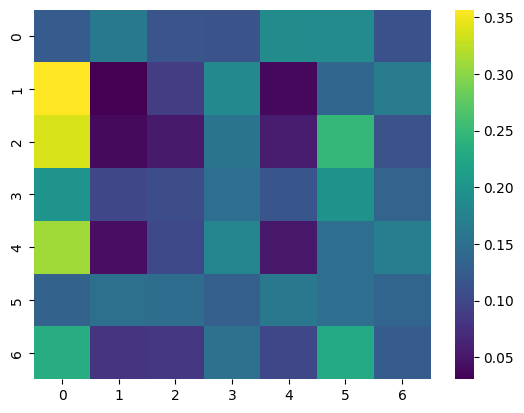

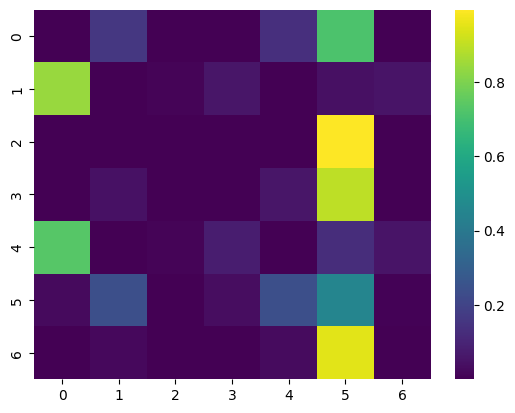

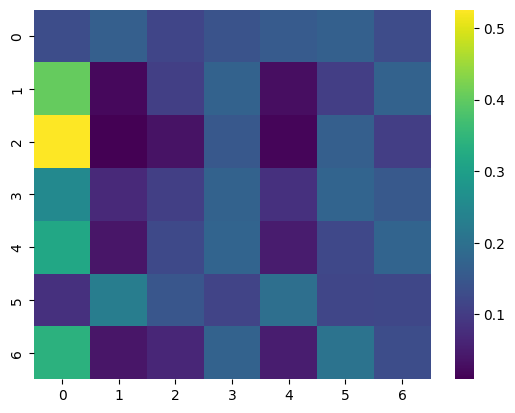

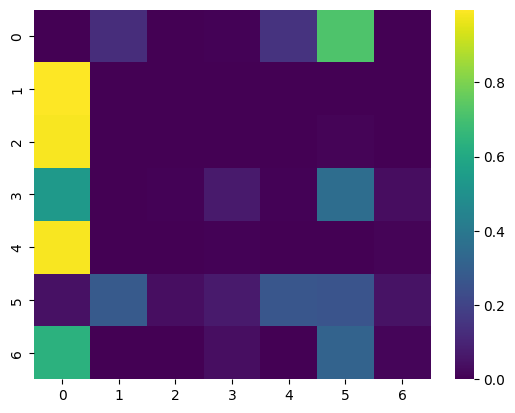

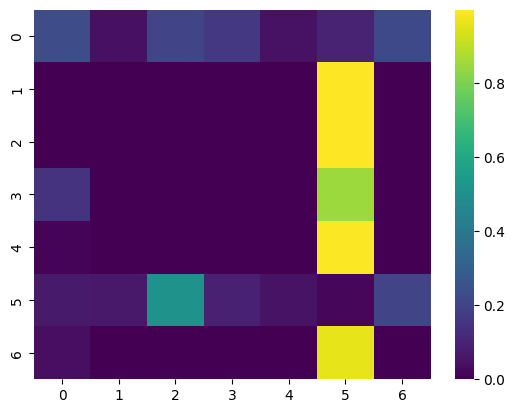

In [7]:
max_epochs = 2000

model = BERT()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.002)

for epoch in range(max_epochs):
    optimizer.zero_grad()
    # @@ logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos, epoch)
    logits_lm, logits_clsf, attention_weights = model(input_ids, segment_ids, masked_pos, epoch)

    # @@ added this
    second_layer_attention = attention_weights[1]

    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    loss_lm = (loss_lm.float()).mean()
    loss_clsf = criterion(logits_clsf, isNext) # for sentence classification
    loss = loss_lm + loss_clsf
    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

    softmax = nn.Softmax(dim=-1)(logits_lm)
    predicted_tokens = torch.argmax(softmax, dim=2)

    logits_clsf_bool = logits_clsf.data.max(1)[1].data.numpy()[0]
    isNextPred = True if logits_clsf_bool else False

    if (epoch == max_epochs-1):
      print("isNext predicted: ", logits_clsf.data.max(1)[1].data.numpy())
      print("isNext actual: ", isNext.data.numpy())

softmax = nn.Softmax(dim=-1)(logits_lm)
predicted_tokens = torch.argmax(softmax, dim=2)

logits_clsf = logits_clsf.data.max(1)[1].data.numpy()[0]

print("predicted_tokens: \n", predicted_tokens)
print("masked_tokens: \n", masked_tokens)

# @@ added
attention_matrix = second_layer_attention[0, 0].detach().numpy()
sns.heatmap(attention_matrix, cmap='viridis')
plt.show()

attention_matrix = second_layer_attention[0, 1].detach().numpy()
sns.heatmap(attention_matrix, cmap='viridis')
plt.show()

attention_matrix = second_layer_attention[0, 2].detach().numpy()
sns.heatmap(attention_matrix, cmap='viridis')
plt.show()

attention_matrix = second_layer_attention[0, 3].detach().numpy()
sns.heatmap(attention_matrix, cmap='viridis')
plt.show()

attention_matrix = second_layer_attention[0, 4].detach().numpy()
sns.heatmap(attention_matrix, cmap='viridis')
plt.show()